# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [2]:
def orig_model(T=20, init_T=15., tOn=16, tOff=20, k=0.01, h=0.5, eps=0.1):
    T = int(T)
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        


# model smoothed with sigmoid (for pyro)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def smooth_orig_model(T=10, init_T=17., tOn=16, tOff=22, k=0.01, h=0.5, eps=0.1, sharpness=100.):
    
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    traj = torch.zeros(T)
    isOn = 0.
    traj[0] = init_T
        
    for i in range(1,T):
        
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn = isOn * (1 - turn_off) + (1 - isOn) * turn_on

        traj[i] = traj[i-1] -k*traj[i-1] + h * isOn + noise.sample()
            
    return traj    

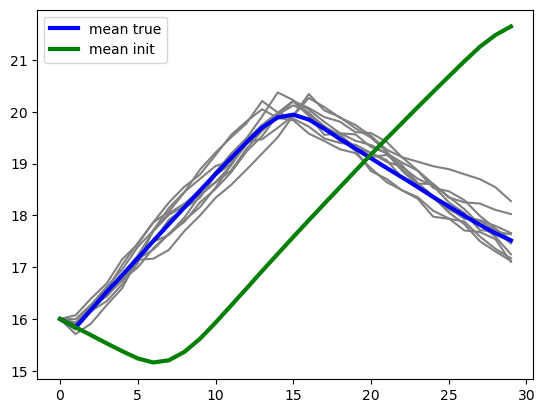

In [7]:
# generation of a set of trajectories for the true paramers value
# we also generate a set of trajectories for the initial parameters value to check that they produce different trajectories

import matplotlib.pyplot as plt

T=30.
init_T = 16.

true_params = {'T':T, 'init_T':init_T, 'tOn':17., 'tOff':20.}
init_params = {'T':T, 'init_T':init_T, 'tOn':15., 'tOff':22.}

true_traj_set = []
init_traj_set = []
#smooth_traj_set = []
for _ in range(500):
    true_traj_set.append(orig_model(**true_params))
    init_traj_set.append(orig_model(**init_params))
    #smooth_traj_set.append(smooth_orig_model())
true_traj_set = torch.vstack(true_traj_set)
init_traj_set = torch.vstack(init_traj_set)
#smooth_traj_set = torch.vstack(smooth_traj_set)

# plotting the first ten trajectories
T = int(T)
for i in range(10):
    plt.plot(range(T), true_traj_set[i], color='grey')

plt.plot(range(T), torch.mean(true_traj_set, 0), lw=3, color='blue', label='mean true')
plt.plot(range(T), torch.mean(init_traj_set, 0), lw=3, color='green', label='mean init')
#plt.plot(range(10), torch.mean(smooth_traj_set, 0), lw=3, color='red', label='mean smoothed')

plt.legend()

### MCMC Optimization

In [83]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
import torch

def pyro_model_mcmc(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    tOn = pyro.sample("tOn", dist.Normal(17.0, 1.0))
    tOff = pyro.sample("tOff", dist.Normal(20.0, 1.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn = torch.zeros(batch_size, dtype=torch.bool)
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        traj[:, i] = traj[:, i - 1] - k * traj[:, i - 1] + noise.sample([batch_size])
        traj[:, i] += h * isOn.float()
        isOn = torch.where((isOn & (traj[:, i] > tOff)) | (~isOn & (traj[:, i] < tOn)), ~isOn, isOn)

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)



def pyro_model_mcmc_smooth(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5, sharpness=0.1):
    
    # higher sharpness means sharper transitions 
    tOn = pyro.sample("tOn", dist.Normal(17.0, 1.0))
    tOff = pyro.sample("tOff", dist.Normal(20.0, 1.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn_prob = torch.zeros(batch_size)  # probability that isOn is True
    noise = dist.Normal(0.0, eps)

    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    for i in range(1, T):
        # Smooth transitions
        turn_on = sigmoid(sharpness * (tOn - traj[:, i-1]))
        turn_off = sigmoid(sharpness * (traj[:, i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on

        traj[:, i] = traj[:, i-1] - k * traj[:, i-1] + h * isOn_prob + noise.sample([batch_size])

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)

In [84]:
# Run NUTS 
nuts_kernel = NUTS(pyro_model_mcmc_smooth)    # NUTS fails to converge (acc. prob = 0.0 both with nonsmooth and smooth)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(traj_set)

# Extract posterior samples
posterior_samples = mcmc.get_samples()
print("Posterior mean tOn:", posterior_samples["tOn"].mean().item())
print("Posterior mean tOff:", posterior_samples["tOff"].mean().item())

Sample: 100%|██████████| 1500/1500 [00:40, 36.81it/s, step size=1.38e-41, acc. prob=0.000]

Posterior mean tOn: -1.157467807305647
Posterior mean tOff: -1.2271539396206728


In [85]:
## Run HMC - TOO SLOW

#hmc_kernel = HMC(pyro_model_mcmc_smooth)
#mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=500, num_chains=1)       
#mcmc.run(traj_set)

## Extract posterior samples

#posterior_samples = mcmc.get_samples()
#print("Posterior mean tOn:", posterior_samples["tOn"].mean().item())
#print("Posterior mean tOff:", posterior_samples["tOff"].mean().item())

MCMC tOn: -1.157467807305647
MCMC tOff: -1.2271539396206728


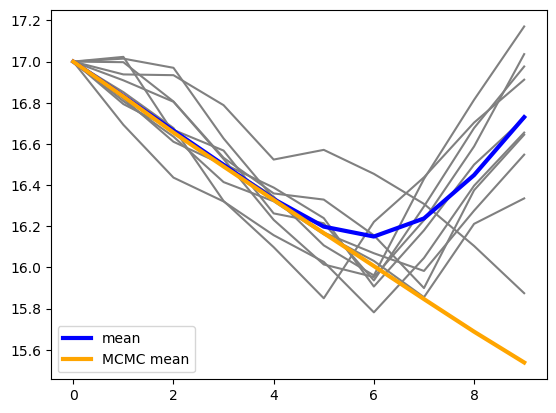

In [86]:
# generation of a trajectories with mcmc parameters

mcmc_tOn = posterior_samples["tOn"].mean().item()
mcmc_tOff = posterior_samples["tOff"].mean().item()

print("MCMC tOn:", mcmc_tOn)
print("MCMC tOff:", mcmc_tOff)

mcmc_set = []
for _ in range(500):
    mcmc_set.append(orig_model(tOn=mcmc_tOn, tOff=mcmc_tOff))
mcmc_set = torch.vstack(mcmc_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')
plt.plot(range(10), torch.mean(mcmc_set, 0), lw=3, color='orange', label='MCMC mean')

plt.legend()

### VI Optimization

In [24]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.nn.functional as F


# Pyro model
def pyro_model(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.1):
    
    tOn = pyro.sample("tOn", distributions.Normal(17.0, 1.0))  
    tOff = pyro.sample("tOff", distributions.Normal(20.0, 1.0))  
    traj = torch.zeros(T)
    traj[0] = init_T
    isOn = False
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        # Update temperature
        if isOn:
            traj[i] = traj[i - 1] - k * traj[i - 1] + h + noise.sample()
        else:
            traj[i] = traj[i - 1] - k * traj[i - 1] + noise.sample() 

        # Update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True

    # Condition on observed trajectories
    N = observed_traj.shape[0]
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)

# Pyro model with smooth transitions

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def pyro_model_smooth(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.1, sharpness=100.):
    
    tOn = pyro.sample("tOn", distributions.Normal(17.0, 1.0))
    tOff = pyro.sample("tOff", distributions.Normal(20.0, 1.0))

    traj = torch.zeros(T)
    traj[0] = init_T                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    isOn_prob = torch.tensor(0.0)  # probability that isOn is True
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        # Update isOn probability smoothly
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on

        # Update temperature (weighted by isOn_prob)
        traj[i] = traj[i-1] - k * traj[i-1] + h * isOn_prob + noise.sample()

    N = observed_traj.shape[0]
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)
    

# Guide (variational distribution)
def pyro_guide(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    
    # Variational parameters for tOn and tOff
    tOn_loc = pyro.param("tOn_loc", torch.tensor(17.0))
    tOff_loc = pyro.param("tOff_loc", torch.tensor(20.0))

    # Sample tOn and tOff from variational distributions
    pyro.sample("tOn", dist.Normal(tOn_loc, torch.tensor(0.5)))
    pyro.sample("tOff", dist.Normal(tOff_loc, torch.tensor(0.5)))

Step 0: Loss = 761745.6564728324
Step 100: Loss = 344159.6829042216
Step 200: Loss = 156792.1803166088
Step 300: Loss = 73714.16177554891
Step 400: Loss = 93826.27874678806
Step 500: Loss = 81626.19148360315
Step 600: Loss = 61527.31382803243
Step 700: Loss = 61265.737988343135
Step 800: Loss = 65011.339106880296
Step 900: Loss = 63608.82812082774
Optimization performed in 1097.68 seconds
Optimized tOn: 15.6384727129495, tOff: 17.244099492816197


Text(0, 0.5, 'Loss')

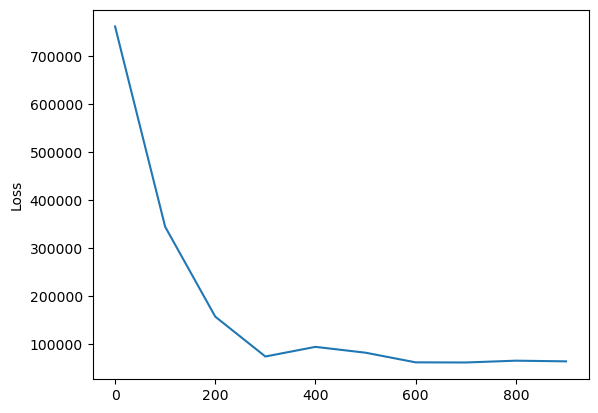

In [ ]:
# SVI setup with smooth model

pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(pyro_model_smooth, pyro_guide, optimizer, loss=Trace_ELBO(num_particles=100))   # with a 100 num_particles and the smooth model the training is more stable
# I put num particles higher to see if the training stabilizes

loss_list = []
step_list = []

# Training loop
num_steps = 1000

start = time()

for step in range(num_steps):
    
    loss = svi.step(traj_set)

    if step % 100 == 0:
        loss_list.append(loss)
        step_list.append(step)
        print(f"Step {step}: Loss = {loss}")
        #for name, value in pyro.get_param_store().items():
        #    print(name, value.grad)


end = time()

print(f"Optimization performed in {end - start:.2f} seconds")

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

plt.plot(step_list, loss_list)
plt.ylabel("Loss")

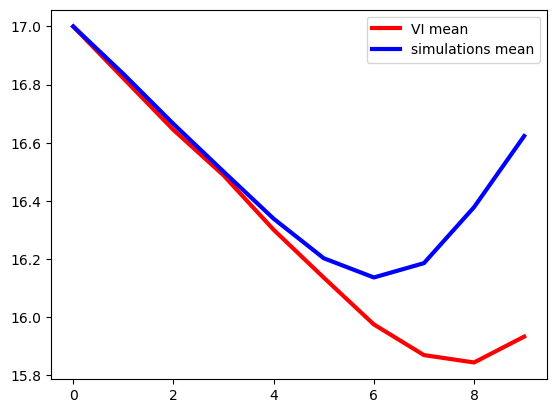

In [38]:
# Trajectories generated using the optimized parameters

import matplotlib.pyplot as plt


vi_traj_set = []
for _ in range(100):
    vi_traj_set.append(orig_model(tOn = vi_tOn, tOff = vi_tOff))
vi_traj_set = torch.vstack(vi_traj_set)


plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')
plt.plot(range(10), torch.mean(smooth_traj_set, 0), lw=3, color='blue', label='simulations mean')

plt.legend()

Step 0: Loss = 638177.5955221631
Step 100: Loss = 592557.9600467084
Step 200: Loss = 646987.420042204
Step 300: Loss = 659272.5090452166
Step 400: Loss = 584870.3266185925
Step 500: Loss = 551140.546577955
Step 600: Loss = 652937.024368906
Step 700: Loss = 648583.8682650761
Step 800: Loss = 565478.4904340265
Step 900: Loss = 647438.3826679761
Optimization performed in 466.20 seconds
Optimized tOn: 17.008052192830682, tOff: 20.00930715211336


Text(0, 0.5, 'Loss')

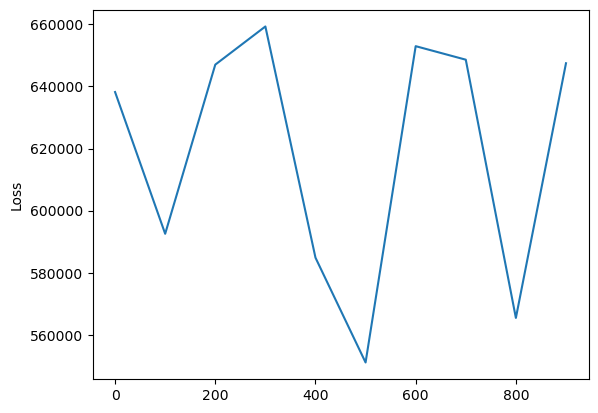

In [39]:
# SVI setup with non-smooth model

pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(pyro_model, pyro_guide, optimizer, loss=Trace_ELBO(num_particles=100))   # with a 100 num_particles and the smooth model the training is more stable
# I put num particles higher to see if the training stabilizes

loss_list = []
step_list = []

# Training loop
num_steps = 1000

start = time()

for step in range(num_steps):
    
    loss = svi.step(traj_set)

    if step % 100 == 0:
        loss_list.append(loss)
        step_list.append(step)
        print(f"Step {step}: Loss = {loss}")
        #for name, value in pyro.get_param_store().items():
        #    print(name, value.grad)


end = time()

print(f"Optimization performed in {end - start:.2f} seconds")

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

plt.plot(step_list, loss_list)
plt.ylabel("Loss")

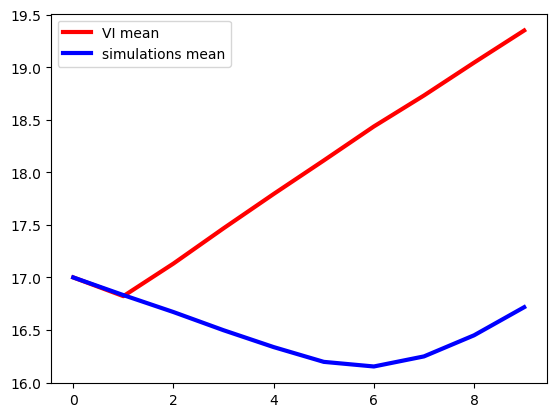

In [40]:
# Trajectories generated using the optimized parameters

import matplotlib.pyplot as plt


vi_traj_set = []
for _ in range(100):
    vi_traj_set.append(orig_model(tOn = vi_tOn, tOff = vi_tOff))
vi_traj_set = torch.vstack(vi_traj_set)


plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')
plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='simulations mean')

plt.legend()

### SOGA Non Bayesian

In [4]:
from optimization import *

Loss value: tensor(14177.3799, grad_fn=<NegBackward0>)


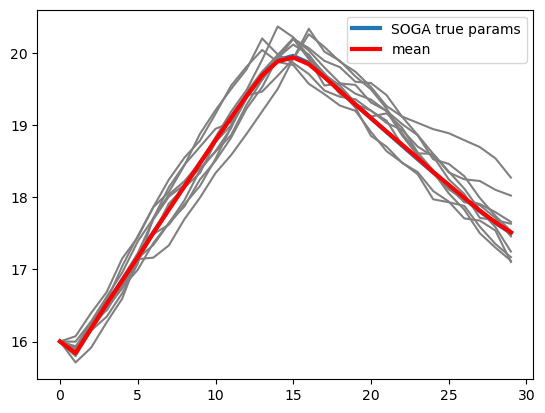

In [11]:
# for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

params_dict = initialize_params(true_params)  

output_dist = start_SOGA(cfg, params_dict)

idx=list(range(1, T))
print('Loss value:', neg_log_likelihood(true_traj_set, output_dist, idx))

y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA true params')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(T), true_traj_set[i], color='grey')

plt.plot(range(T), torch.mean(true_traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

Loss value: tensor(42990.3265, grad_fn=<NegBackward0>)


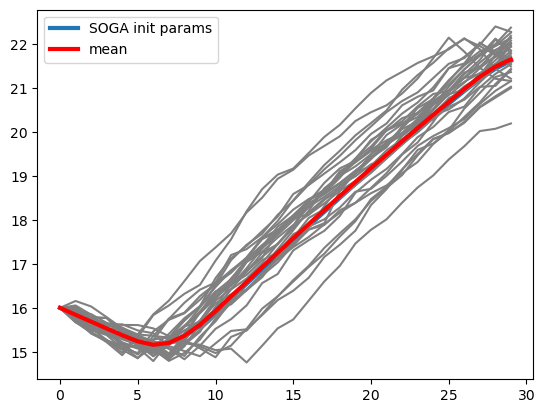

In [12]:
# we choose as initial value of the parameter a value for which the loss is higher and there is a significant difference
# in the mean 

compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

params_dict = initialize_params(init_params)  

output_dist = start_SOGA(cfg, params_dict)

print('Loss value:', neg_log_likelihood(true_traj_set, output_dist, idx))

y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')

# plotting the first ten trajectories
for i in range(T):
    plt.plot(range(T), init_traj_set[i], color='grey')

plt.plot(range(T), torch.mean(init_traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [13]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
params_dict = initialize_params(init_params)

loss = lambda dist : neg_log_likelihood(true_traj_set, dist, idx)

compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

optimize(cfg, params_dict, loss, n_steps=100, lr=0.1)


T: 30.0 init_T: 16.0 tOn: 15.099999999999946 tOff: 21.90000000000006  loss: 42990.32650843053
T: 30.0 init_T: 16.0 tOn: 16.029961784112086 tOff: 20.937694340322548  loss: 18131.70509119502
T: 30.0 init_T: 16.0 tOn: 16.48910154194602 tOff: 20.19692837076659  loss: 14436.308922583146
T: 30.0 init_T: 16.0 tOn: 16.666036958538182 tOff: 19.81019101575653  loss: 14267.55525967265
T: 30.0 init_T: 16.0 tOn: 16.736865716098407 tOff: 19.77028517127421  loss: 14364.48593669753
T: 30.0 init_T: 16.0 tOn: 16.76620116439752 tOff: 19.901017928801032  loss: 14214.258614832837
T: 30.0 init_T: 16.0 tOn: 16.778956967039676 tOff: 20.010838737860016  loss: 14179.833366347179
T: 30.0 init_T: 16.0 tOn: 16.784715378414873 tOff: 20.031900912564655  loss: 14186.950282124275
T: 30.0 init_T: 16.0 tOn: 16.78772973283209 tOff: 20.001527661921557  loss: 14179.938546240799
T: 30.0 init_T: 16.0 tOn: 16.7900476539415 tOff: 19.97596590706429  loss: 14178.588982639856
Optimization performed in  320.125


In [14]:
params_dict

{'T': tensor(30., requires_grad=True),
 'init_T': tensor(16., requires_grad=True),
 'tOn': tensor(16.7922, requires_grad=True),
 'tOff': tensor(19.9738, requires_grad=True)}

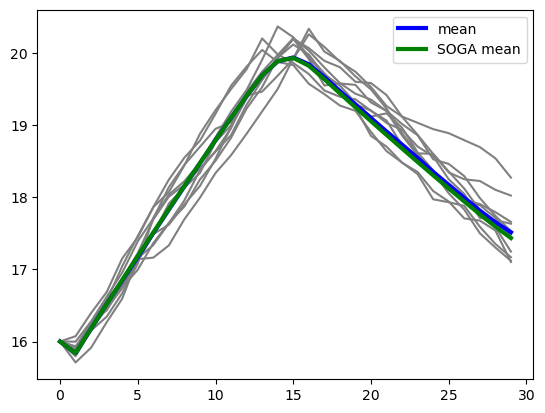

In [19]:
# Printing the trajectories generated with the optimized parameters

compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
loss(output_dist)

import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(T), true_traj_set[i], color='grey')

plt.plot(range(T), torch.mean(true_traj_set, 0), lw=3, color='blue', label='mean')

#plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')

#plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')

plt.legend()

#### Batch optimization

In [20]:
def batch_optimize(cfg, params_dict, traj_set, loss_func, batch_size=100, n_steps=100, lr=0.05):

    # creates the optimizer, passing the parameters of the program as the parameters to optimize
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=lr)

    total_start = time()

    N = traj_set.shape[0]

    for i in range(n_steps):

        optimizer.zero_grad()  # Reset gradients

        # Sample a batch of trajectories
        indices = np.random.choice(N, batch_size, replace=False)
        batch = traj_set[indices]
    
        # loss
        current_dist = start_SOGA(cfg, params_dict)     # we compute the output distribution for the current values of the parameters using start_SOGA    
        loss = loss_func(batch, current_dist)        # we compute the loss using the set of trajectories and the current output distribution

        # Backpropagate
        loss.backward()
    
        # Update parameters
        optimizer.step()

        # Print progress
        if i % int(n_steps/10) == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))

In [22]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
params_dict = initialize_params(init_params)

batch_loss = lambda batch, dist : neg_log_likelihood(batch, dist, idx)

compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

batch_optimize(cfg, params_dict, true_traj_set, batch_loss, n_steps=100, lr=0.1)


T: 30.0 init_T: 16.0 tOn: 15.09999999999973 tOff: 21.900000000000304  loss: 8586.640465113593
T: 30.0 init_T: 16.0 tOn: 16.029857000385118 tOff: 20.938958975045406  loss: 3643.2964243288657
T: 30.0 init_T: 16.0 tOn: 16.489017402967768 tOff: 20.20051065934943  loss: 2875.891698113012
T: 30.0 init_T: 16.0 tOn: 16.665971035703652 tOff: 19.812625512457306  loss: 2850.7660962192886
T: 30.0 init_T: 16.0 tOn: 16.73688263614308 tOff: 19.77114532310969  loss: 2859.1428594552076
T: 30.0 init_T: 16.0 tOn: 16.76604724482919 tOff: 19.905110594518106  loss: 2842.5245800913444
T: 30.0 init_T: 16.0 tOn: 16.77859963981188 tOff: 20.01311127408621  loss: 2838.0180745677662
T: 30.0 init_T: 16.0 tOn: 16.784257710217517 tOff: 20.037090281858475  loss: 2842.9241173338537
T: 30.0 init_T: 16.0 tOn: 16.787050494904047 tOff: 20.004143712494663  loss: 2834.819380601767
T: 30.0 init_T: 16.0 tOn: 16.78939559361859 tOff: 19.976968929967875  loss: 2841.3617006597597
Optimization performed in  372.058


### SOGA Bayesian

In [45]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/ThermostatBayesian.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'tOffMean':22., 'tOnMean':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist_bayesian = start_SOGA(cfg, params_dict)

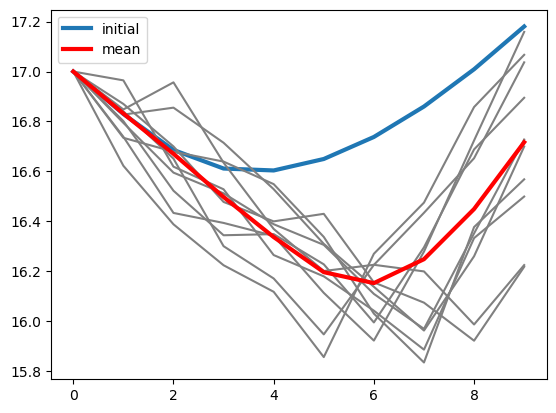

In [46]:
import matplotlib.pyplot as plt

y_init = output_dist_bayesian.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [97]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist_bayesian)

tensor(1738.6514, grad_fn=<NegBackward0>)

In [ ]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOffMean':22., 'tOnMean':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimize(cfg, traj_set, params_dict, neg_log_likelihood, n_steps=100, lr=0.25)


TypeError: optimize() got multiple values for argument 'n_steps'

In [99]:
params_dict

{'tOffMean': tensor(21.7461, requires_grad=True),
 'tOnMean': tensor(14.5592, requires_grad=True)}

In [100]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/ThermostatBayesian.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist_bayesian = start_SOGA(cfg, params_dict)

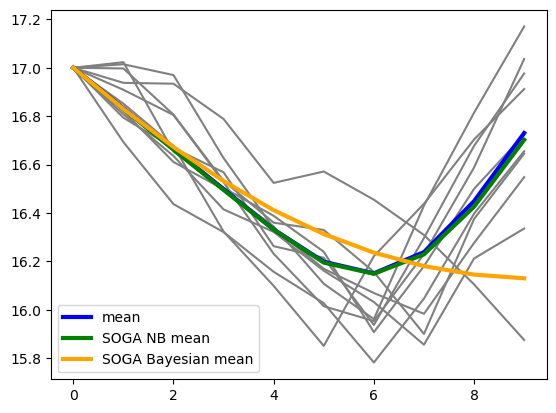

In [102]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')

#plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='SOGA NB mean')

plt.plot(range(10), output_dist_bayesian.gm.mean()[:10].detach(), lw=3, color='orange', label='SOGA Bayesian mean')


#plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')

plt.legend()

## Analysis of gradient behaviour

In [46]:
# original model without noise
def det_orig_model(T=10, init_T=17., tOn=16, tOff=20, k=0.01, h=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj    


# model smoothed with sigmoid (for pyro)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def smooth_orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.1, sharpness=1.):
    
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    traj = torch.zeros(T)
    isOn = 0.
    traj[0] = init_T
        
    for i in range(1,T):
        
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn = isOn * (1 - turn_off) + (1 - isOn) * turn_on

        traj[i] = traj[i-1] -k*traj[i-1] + h * isOn + noise.sample()
            
    return traj    

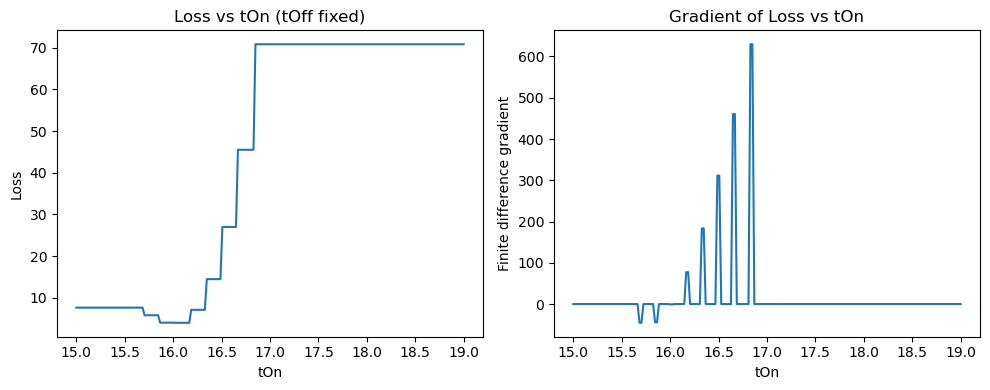

In [47]:
# without noise the model is discontinuous 

import numpy as np
import matplotlib.pyplot as plt


# does it make sense to use this? 
def loss_for_params(model, tOn, tOff, batch_size):
    # Use the original model to generate trajectories with fixed tOn, tOff
    # and compute negative log likelihood on the observed data
    trajs = []
    for _ in range(batch_size):  # use a small batch for speed
        trajs.append(model(tOn=tOn, tOff=tOff))
    trajs = torch.vstack(trajs)
    # Negative log likelihood under the observed data
    # (use the same likelihood as in your SVI)
    with torch.no_grad():
        loss = 0
        for i in range(traj_set.shape[0]):
            loss += -torch.distributions.Normal(trajs.mean(0), 0.5).log_prob(traj_set[i]).sum()
        loss /= traj_set.shape[0]   # added normalization
    return loss.item()

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 200)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(det_orig_model, tOn, tOff_fixed, batch_size=1))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

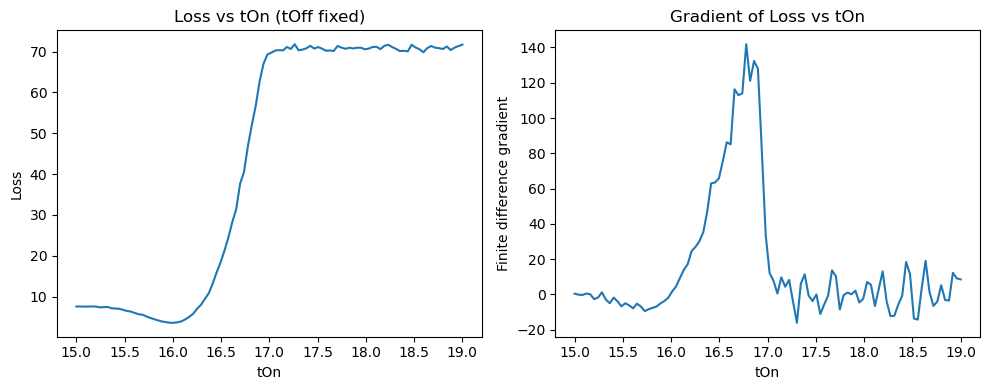

In [48]:
# with noise the loss is continuous but the gradient oscillates a lot

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

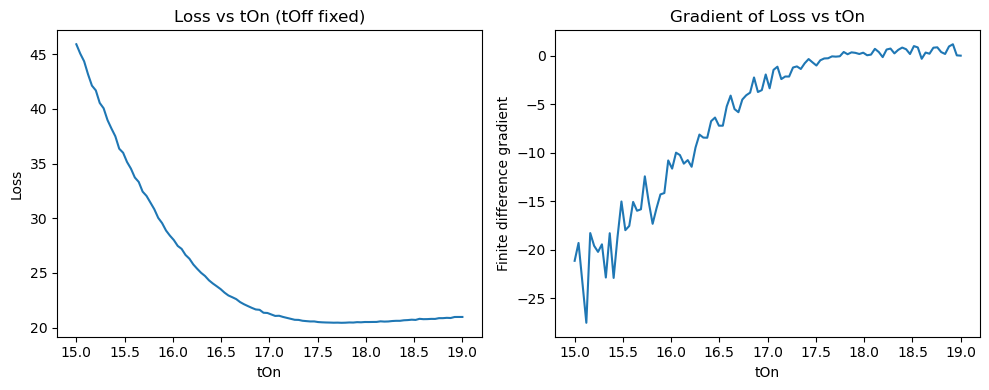

In [ ]:
# with smoothing

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(smooth_orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()